In [85]:
import charts_function_list
import os

In [277]:
base_path,data,outputs = charts_function_list.folder_setup()

In [278]:
os.chdir(data)

In [88]:
board_games = pd.read_csv('bgg_db_2017_04.csv',encoding='latin-1')

### Some initial explorations

In [70]:
board_games.corr()[board_games.corr()>.5].fillna('')

,rank,game_id,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,owned,weight
rank,1,,,,,,,,,,,,,
game_id,,1,,,,,,,,,,,,
min_players,,,1,,,,,,,,,,,
max_players,,,,1,,,,,,,,,,
avg_time,,,,,1,0.873736,0.999909,,,,,,,
min_time,,,,,0.873736,1,0.873613,,,,,,,
max_time,,,,,0.999909,0.873613,1,,,,,,,
year,,,,,,,,1,,,,,,
avg_rating,,,,,,,,,1,,,,,0.538311
geek_rating,,,,,,,,,,1,0.636099,,0.629257,


### A look at the top most prolific designers' games

In [89]:

board_games = board_games[~board_games['designer'].isin(['(Uncredited)','none'])].reset_index(drop=True)
#board_games = board_games[board_games['num_votes']>=board_games['num_votes'].median()]  #filter to only include games rated > than median

rating_group_ = board_games.groupby('designer')
agg_funcs = {'geek_rating':np.mean,'names':np.count_nonzero}
rating_frame = rating_group_.agg(agg_funcs)
rating_frame.sort_values(by='names',ascending=False,inplace=True)

def top_ratings(df_ranks,df_full,values=5):
    top_list = df_ranks.head(values)
    top_df = df_full[df_full['designer'].isin(top_list.index)].reset_index(drop=True)
    design_map = {v:i for i,v in enumerate(top_df['designer'].unique())}
    top_df.loc[:,'cmap'] = top_df['designer'].map(design_map)
    return top_df

In [90]:
top_5_ratings = top_ratings(rating_frame,board_games,values=5)
top_10_ratings = top_ratings(rating_frame,board_games,values=10)

In [192]:
max_scores = top_10_ratings.groupby('designer').max()['geek_rating']

top_max_scores = top_10_ratings[(top_10_ratings['designer'].isin(max_scores.index))&top_10_ratings['geek_rating'].isin(max_scores)][['designer','geek_rating','names']]

top_max_scores = top_max_scores.merge(pd.DataFrame(top_10_ratings.groupby('designer').agg({'median','count'})['geek_rating']),
                     left_on='designer',right_index=True).sort_values(by='median').reset_index(drop=True)


top_max_scores['designer_']=top_max_scores['designer'].replace({'Michael Kiesling, Wolfgang Kramer':'Michael Kiesling,\nWolfgang Kramer'})

top_max_scores['names_']= top_max_scores['names'].replace({'Thunderbolt Apache Leader':'Thunderbolt\nApache Leader',
                                                          'Tigris & Euphrates':'Tigris &\nEuphrates',
                                                          'Brass: Lancashire':'Brass:\nLancashire',
                                                          'Caverna: The Cave Farmers':'Caverna:\nThe Cave Farmers',
                                                          'The Castles of Burgundy':'The Castles\nof Burgundy'})

### Creating box plot

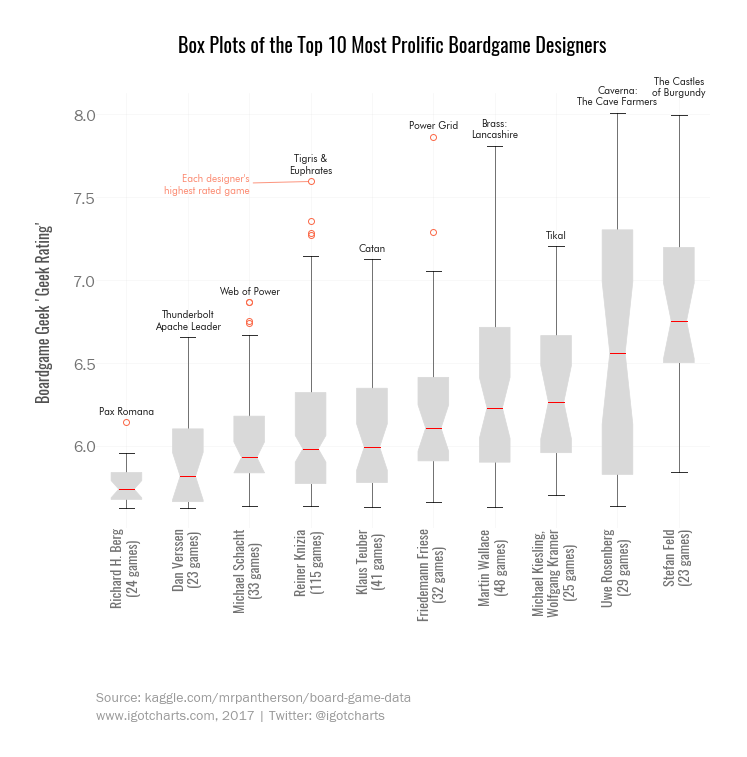

In [280]:
#empty list
os.chdir(outputs)
data = []

#set up objects
box_plots_ = charts_function_list.chart_maker('Box Plots of the Top 10 Most Prolific Boardgame Designers',title_size=20)
fig = box_plots_.initial_fig_axis(figsize=(11,8))
fig.suptitle(box_plots_.title,fontname='Oswald',size=box_plots_.title_size)
ax = box_plots_.axes_set_up(fig)


#set up data for box plot
for i in top_max_scores['designer'].values:
    data.append(top_10_ratings[top_10_ratings['designer']==i]['geek_rating'])
    
#boxplot    
plt.boxplot(data,patch_artist=True,boxprops=dict(facecolor='#d9d9d9', color='#d9d9d9',linewidth=.7),notch=True,
            medianprops=dict(color='red'),whiskerprops=dict(color='#737373'),capprops=dict(color='black',alpha=.8),
           flierprops = dict(markeredgecolor='#fb6a4a'))



#setting up ticks
box_plots_.tick_params_(ax,labelcolor='#737373')

#labelling x with designer and games
ax.set_xticklabels([top_max_scores['designer_'].values[x]+'\n('+str(top_max_scores['count'].values[x])+' games)' for x in range(len(top_max_scores))],rotation=90,fontname='Oswald',weight='normal',fontsize=14)

#setting up y label
ax.set_ylabel('Boardgame Geek \'Geek Rating\'',size=16,color='#525252',labelpad=20,fontname='Oswald')

#labelling max points
for item in range(len(top_max_scores)-1):
    ax.text(top_max_scores.index[item]+1,top_max_scores['geek_rating'][item]+.05,top_max_scores['names_'][item],
            ha='center',fontname='Futura Bk BT',alpha=.9)
    
    
ax.text(top_max_scores.index[-1]+1,top_max_scores.iloc[-1,top_max_scores.columns.get_loc('geek_rating')]+.12,top_max_scores.iloc[-1,top_max_scores.columns.get_loc('names_')],ha='center',fontname='Futura Bk BT',alpha=.9)

ax.annotate('Each designer\'s\nhighest rated game',xy=(4,7.596),xytext=(3,7.58),arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3",color='#fb6a4a',alpha=.7),fontname='Futura Bk BT',fontsize=10,alpha=.8,color='#fb6a4a',ha='right',va='center')

#add citations
box_plots_.citations(ax,source='Source: kaggle.com/mrpantherson/board-game-data',chart_tag_y=-.44)
charts_function_list.chart_save('Boardgames',dpi=200)
plt.show()

### Other explorations

In [229]:
board_games.corr()[board_games.corr()>.5].fillna('')

,rank,game_id,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,owned,weight
rank,1,,,,,,,,,,,,,
game_id,,1,,,,,,,,,,,,
min_players,,,1,,,,,,,,,,,
max_players,,,,1,,,,,,,,,,
avg_time,,,,,1,0.874,1,,,,,,,
min_time,,,,,0.874,1,0.874,,,,,,,
max_time,,,,,1,0.874,1,,,,,,,
year,,,,,,,,1,,,,,,
avg_rating,,,,,,,,,1,,,,,0.54
geek_rating,,,,,,,,,,1,0.635,,0.629,


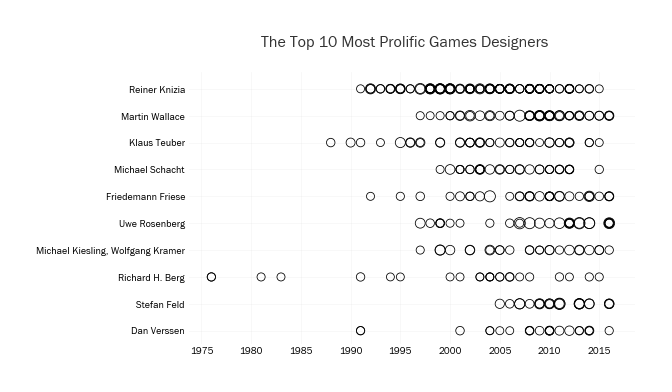

In [14]:
#playing with scatters

scatter_top = charts_function_list.chart_maker('The Top 10 Most Prolific Games Designers')
fig = scatter_top.initial_fig_axis(figsize=(8,5))
ax = scatter_top.axes_set_up(fig)

def top_scatters(df,cmap='Dark2'):
    value_counts_ = df['designer'].value_counts().sort_values(ascending=True)
    

    for i,v in enumerate(value_counts_):
        a = df[df['designer']==value_counts_.index[i]]
        plt.scatter(a['year'],
                    np.linspace(i,i,len(a)),
                   s=(a['geek_rating']**2)*2,facecolor='none',edgecolor='black',linewidth=.8)
        
    return value_counts_

abc = top_scatters(top_10_ratings)
ax.set_yticks([i for i,v in enumerate(abc.index)])
ax.set_yticklabels([v for i,v in enumerate(abc.index)])

plt.show()


#box plots .. 

### Preliminary look at top board game designers with k-means

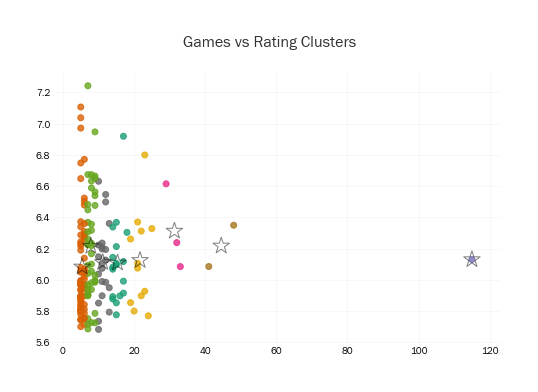

In [11]:
#assess via kmeans

top_designers = board_games['designer'].value_counts()[board_games['designer'].value_counts()>=5]
board_games_top_design=board_games[board_games['designer'].isin(top_designers.index)]

rating_group_top = board_games_top_design.groupby('designer')

rating_frame_top = rating_group_top.agg(agg_funcs)



from sklearn.cluster import KMeans

f1 = rating_frame_top['geek_rating'].values
f2 = rating_frame_top['names'].values

X=np.matrix(list(zip(f1,f2)))
kmeans = KMeans(n_clusters=8,algorithm='auto',n_init=50).fit(X)

chart_object = charts_function_list.chart_maker('Games vs Rating Clusters')
fig = chart_object.initial_fig_axis(figsize=(8,5))
ax = chart_object.axes_set_up(fig)
ax.scatter(f2,f1,alpha=.8,c=kmeans.labels_,zorder=1,cmap='Dark2')
for x,y in kmeans.cluster_centers_ :
    ax.scatter(y,x,marker='*',facecolors='none',s=300,zorder=2,alpha=.5,edgecolor='black')
plt.show()
